## Predict Bike Sharing Demand with AutoGluon Template

In [13]:
#!pip install -U pip
#!pip install -U setuptools wheel
#!pip install -U "mxnet<2.0.0" bokeh==2.0.1
#!pip install autogluon --no-cache-dir
#!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 1.0 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.12-py3-none-any.whl size=102985 sha256=4fd972bbbe73cb22e04486f0a0ca192ffd38f4e6ee220b73ee98682402f845d0
  Stored in directory: /root/.cache/pip/wheels/1e/0b/7c/50f8e89c3d2f82838dbd7afeddffbb9357003009ada98216c7
Successfully built kaggle


In [14]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [15]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "karolaydelacruz"
kaggle_key = "04ea8b88c9ba188eae863f92242bfb79"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [17]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [18]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [21]:

# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv',parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [22]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [23]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv',parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [25]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv',parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction


Requirements:

- We are prediting count, so it is the label we are setting.
- Ignore casual and registered columns as they are also not present in the test dataset.
- Use the root_mean_squared_error as the metric to use for evaluation.
- Set a time limit of 10 minutes (600 seconds).
- Use the preset best_quality to focus on creating the best model.

In [26]:
predictor = TabularPredictor(
    label="count", problem_type="regression", eval_metric="rmse").fit(
    train_data=train.drop(['casual', 'registered'], axis=1),
    time_limit=600,presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240512_231942"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240512_231942/ds_sub_fit/sub_fit_ho.
2024-05-12 23:19:42,779	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.

### Review AutoGluon's training run with ranking of models that did the best.

In [27]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -55.092171  root_mean_squared_error      22.910161  336.083052                0.000729           0.065980            3       True         11
1          LightGBM_BAG_L2  -55.149549  root_mean_squared_error      18.056607  272.682853                0.375233          29.214949            2       True         10
2        LightGBMXT_BAG_L2  -60.585107  root_mean_squared_error      22.534199  306.802123                4.852824          63.334219            2       True          9
3    KNeighborsDist_BAG_L1  -84.125061  root_mean_squared_error       0.081697    0.046970                0.081697           0.046970            1       True          2
4      WeightedEnsemble_L2  -84.125061  root_mean_squared_error       0.082440    0.175766   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54835939455667,
  'CatBoost_BAG_L1': -130.93766256745465,
  'ExtraTreesMSE_BAG_L1': -124.60067564699747,
  'WeightedEnsemble_L2': -84.12506123181602,
  'LightGBMXT_BAG_L2': -60.58

### Create predictions from test dataset

In [31]:
predictions = pd.DataFrame({'datetime': test['datetime'], 'count_val':  predictor.predict(test)})
predictions.head()

,datetime,count_val
0,2011-01-20 00:00:00,35.513115
1,2011-01-20 01:00:00,44.996498
2,2011-01-20 02:00:00,49.229824
3,2011-01-20 03:00:00,52.417130
4,2011-01-20 04:00:00,53.668056


#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [32]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

,datetime,count_val
count,6493,6493.000000
mean,2012-01-13 09:27:47.765285632,99.909462
min,2011-01-20 00:00:00,-4.214993
25%,2011-07-22 15:00:00,16.531172
50%,2012-01-20 23:00:00,63.261909
75%,2012-07-20 17:00:00,172.047211
max,2012-12-31 23:00:00,378.957214
std,NaN,90.141296


In [33]:
# How many negative values do we have?
len(predictions[predictions.count_val<0])

7

In [34]:
# Set them to zero
predictions[predictions.count_val<0]=0

/tmp/ipykernel_19/3654980907.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  predictions[predictions.count_val<0]=0


In [35]:
predictions.describe()

,count_val
count,6493.000000
mean,99.911453
std,90.139061
min,0.000000
25%,16.531172
50%,63.261909
75%,172.047211
max,378.957214


### Set predictions to submission dataframe, save, and submit

In [37]:
submission["count"] = predictions["count_val"] 
submission.to_csv("submission.csv", index=False)

In [38]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"


100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 670kB/s]
Successfully submitted to Bike Sharing Demand

### View submission via the command line or in the web browser under the competition's page - My Submissions

In [39]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2024-05-12 23:33:55  first raw submission  complete  1.85504      1.85504       


#### Initial score of 1.85504

### Step 4: Exploratory Data Analysis and Creating an additional feature
- Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>]], dtype=object)

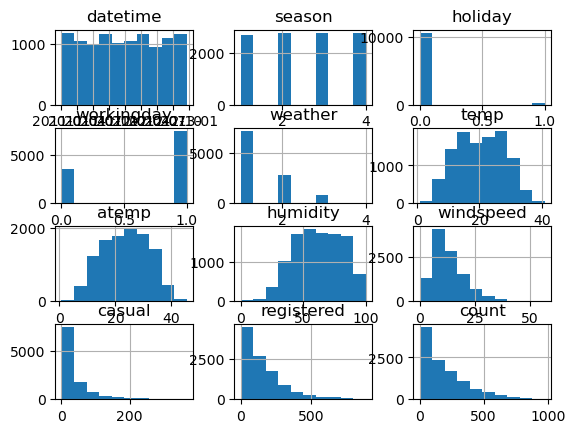

In [40]:

# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [41]:
# create a new feature
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

In [42]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour

In [43]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


### Make category types for these so models know they are not just numbers
- AutoGluon originally sees these as ints, but in reality they are int representations of a category.
- Setting the dtype to category will classify these as categories in AutoGluon.

In [44]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [45]:
# View are new feature
train.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'casual'}>],
       [<Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'hour'}>, <Axes: >, <Axes: >]],
      dtype=object)

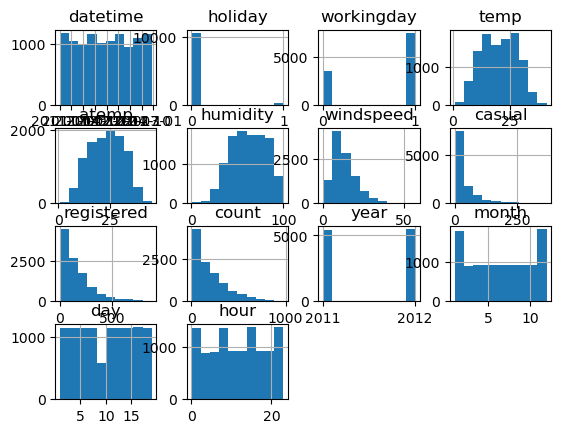

In [46]:
# View histogram of all features again now with the hour feature
train.hist()

### Step 5: Rerun the model with the same settings as before, just with more features

In [48]:
predictor_new_features = TabularPredictor(
    label="count", problem_type="regression", eval_metric="rmse").fit(
    train_data=train.drop(['casual', 'registered'], axis=1),
    time_limit=600,presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240512_234456"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240512_234456/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 176 seconds

In [49]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.379227  root_mean_squared_error      31.529342  379.408636                0.001791           0.102033            3       True         12
1          LightGBM_BAG_L2  -30.633891  root_mean_squared_error      29.087747  296.798819                0.403776          31.988052            2       True         10
2        LightGBMXT_BAG_L2  -31.197901  root_mean_squared_error      30.449488  304.398075                1.765517          39.587308            2       True          9
3   RandomForestMSE_BAG_L2  -31.747459  root_mean_squared_error      29.358259  307.731242                0.674288          42.920475            2       True         11
4      WeightedEnsemble_L2  -32.347942  root_mean_squared_error      27.824208  257.457465   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.453884062670745,
  'LightGBM_BAG_L1': -33.91733862651761,
  'RandomForestMSE_BAG_L1': -38.424983594881716,
  'CatBoost_BAG_L1': -35.7071037987474,
  'ExtraTreesMSE_BAG_L1': -38.10727767243523,
  'WeightedEnsemble_L

In [52]:
# Remember to set all negative values to zero
predictions_new_features = pd.DataFrame({'datetime': test['datetime'], 'count_val':  predictor_new_features.predict(test)})
predictions_new_features[predictions_new_features['count_val']<0] = 0
predictions_new_features.describe()

,datetime,count_val
count,6493,6493.000000
mean,2012-01-13 09:27:47.765285632,164.005814
min,2011-01-20 00:00:00,1.550171
25%,2011-07-22 15:00:00,49.182907
50%,2012-01-20 23:00:00,125.312988
75%,2012-07-20 17:00:00,232.786728
max,2012-12-31 23:00:00,818.101929
std,NaN,146.750504


In [53]:
# Same submitting predictions
submission_new_features = pd.read_csv('submission.csv')
submission_new_features["count"] = predictions_new_features['count_val']
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [54]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 572kB/s]
Successfully submitted to Bike Sharing Demand

In [55]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2024-05-13 00:00:14  new features          complete  0.61513      0.61513       
submission.csv               2024-05-12 23:33:55  first raw submission  complete  1.85504      1.85504       


#### New Score of 0.615

### Step 6: Hyper parameter optimization

- There are many options for hyper parameter optimization.
- Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
- The hyperparameters of the models themselves that are in AutoGluon. Those need the hyperparameter and hyperparameter_tune_kwargs arguments.

In [59]:
predictor_new_hpo = TabularPredictor(
    label="count", problem_type="regression", eval_metric="rmse").fit(
    train_data=train.drop(['casual', 'registered'], axis=1),
    time_limit=600,presets='best_quality',
    hyperparameter_tune_kwargs={'num_trials': 4,'searcher': 'random'})

No path specified. Models will be saved in: "AutogluonModels/ag-20240513_000426"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240513_000426/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 70 seconds 

In [60]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val              eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  LightGBMLarge_BAG_L2 -46.019351  root_mean_squared_error       0.340706  49.684463                0.190995          26.706947            2       True          3
1   WeightedEnsemble_L3 -46.019351  root_mean_squared_error       0.342205  49.709542                0.001499           0.025079            3       True          4
2  LightGBMLarge_BAG_L1 -57.649465  root_mean_squared_error       0.149710  22.977516                0.149710          22.977516            1       True          1
3   WeightedEnsemble_L2 -57.649465  root_mean_squared_error       0.152556  22.993217                0.002846           0.015701            2       True          2
Number of models trained: 4
Types of models trained:
{'StackerEnsembleModel_LGB', 'WeightedEnsembleModel'}
Bagging use

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMLarge_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMLarge_BAG_L1': -57.64946484192091,
  'WeightedEnsemble_L2': -57.64946484192091,
  'LightGBMLarge_BAG_L2': -46.01935119994042,
  'WeightedEnsemble_L3': -46.01935119994042},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'LightGBMLarge_BAG_L1': ['LightGBMLarge_BAG_L1'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2'],
  'LightGBMLarge_BAG_L2': ['LightGBMLarge_BAG_L2'],
  'WeightedEnsemble_L3': ['WeightedEnsemble_L3']},
 'model_fit_times': {'LightGBMLarge_BAG_L1': 22.977515697479248,
  'WeightedEnsemble_L2': 0.0157010555267334,
  'LightGBMLarge_BAG_L2': 26.706947326660156,
  'WeightedEnsemble_L3': 0.02507925033569336},
 'model_pred_times': {'LightGBMLarge_BAG_L1': 0.14971041679382324,
  'WeightedEnsemble_L2': 0.00284552574157714

In [61]:
# Remember to set all negative values to zero
predictions_new_hpo = pd.DataFrame({'datetime': test['datetime'], 'count_val':  predictor_new_hpo.predict(test)})
predictions_new_hpo[predictions_new_hpo['count_val']<0] = 0
predictions_new_hpo.describe()

,datetime,count_val
count,6493,6493.000000
mean,2012-01-13 09:27:47.765285632,194.809952
min,2011-01-20 00:00:00,24.516935
25%,2011-07-22 15:00:00,62.594688
50%,2012-01-20 23:00:00,156.379944
75%,2012-07-20 17:00:00,271.538147
max,2012-12-31 23:00:00,823.008118
std,NaN,159.201340


In [62]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('submission.csv')
submission_new_hpo["count"] = predictions_new_hpo['count_val']
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [63]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 593kB/s]
Successfully submitted to Bike Sharing Demand

In [64]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-05-13 00:06:41  new features with hyperparameters  complete  0.74647      0.74647       
submission_new_features.csv  2024-05-13 00:00:14  new features                       complete  0.61513      0.61513       
submission.csv               2024-05-12 23:33:55  first raw submission               complete  1.85504      1.85504       


#### New Score of 0.746

### Step 7: Write a Report
#### Refer to the markdown file for the full report
#### Creating plots and table for report

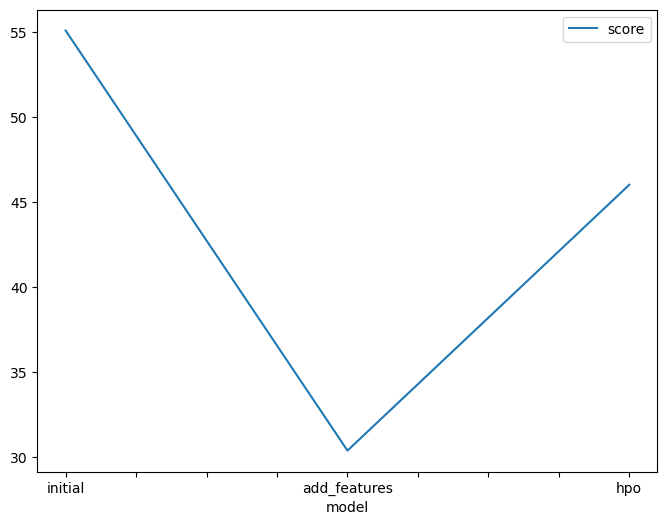

In [65]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [55.092171, 30.379227, 46.019351]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

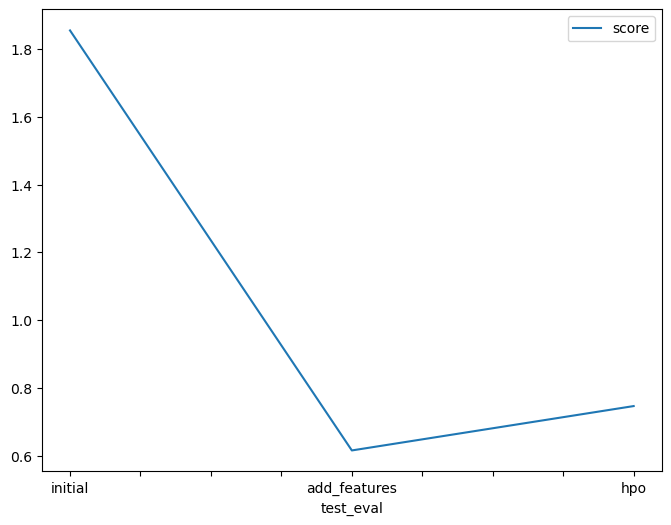

In [66]:

# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.85504, 0.615,  0.746]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

#### Hyperparameter table

In [77]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ['best quality,10 min', 'best quality,10 min', 'best quality,10 min'],
    "hpo2": ['-', 'additional features', 'additional features'],
    "hpo3": ['-', '-', 'Hyper parameter optimization'],
    "score": [1.85504, 0.615,  0.746]
})

,model,hpo1,hpo2,hpo3,score
0,initial,"best quality,10 min",-,-,1.85504
1,add_features,"best quality,10 min",additional features,-,0.61500
2,hpo,"best quality,10 min",additional features,Hyper parameter optimization,0.74600
